In [37]:
import torch
import torchvision
import torchvision.transforms as transforms

def print_torch_versions():
    """
    Prints the version of torch and torchvision.
    """
    print(torch.__version__)    
    print(torchvision.__version__)


print_torch_versions()


1.13.1
0.14.1


In [38]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [39]:
# Load CIFAR-10 dataset using torchvision
# The output of torchvision datasets are PILImage images of range [0, 1].

train_cifar10 = torchvision.datasets.CIFAR10(
    root="cifar-10",
    train=True,
    transform=transforms.Compose(
        [
            transforms.Resize(size=(227, 227)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.4914, 0.4822, 0.4465], std=[0.4914, 0.4822, 0.4465]
            ),
        ]
    ),
    download=True,
)
test_cifar10 = torchvision.datasets.CIFAR10(
    root="cifar-10",
    train=False,
    transform=transforms.Compose(
        [
            transforms.Resize(size=(227, 227)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.4914, 0.4822, 0.4465], std=[0.4914, 0.4822, 0.4465]
            ),
        ]
    ),
    download=True,
)

# For Mean and Standard Deviation values refer --> https://stackoverflow.com/a/69699979

Files already downloaded and verified
Files already downloaded and verified


In [40]:
# Code to split the train dataset into train and validation dataset
train_split_cifar10, val_split_cifar10 = torch.utils.data.random_split(train_cifar10, [45000, 5000])

In [41]:
# Code to print the number of samples in train and test dataset
print("Number of samples in train dataset: ", len(train_split_cifar10))
print("Number of samples in validation dataset: ", len(val_split_cifar10))
print("Number of samples in test dataset: ", len(test_cifar10))

Number of samples in train dataset:  45000
Number of samples in validation dataset:  5000
Number of samples in test dataset:  10000


In [52]:
"""
Get the list of class names from the CIFAR10 training dataset.

Returns:
classnames (list): A list of class names.
"""
classnames = train_cifar10.classes

print("CIFAR10 classes: ", classnames)

CIFAR10 classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [43]:
# Hyperparameters

# Number of training epochs
EPOCHS = 20

# Batch size for training
BATCH_SIZE = 64

# Learning Rate
LEARNING_RATE = 0.003

In [44]:
# define train, validation and test data loaders

train_loader = torch.utils.data.DataLoader(train_split_cifar10, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_split_cifar10, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_cifar10, batch_size=BATCH_SIZE, shuffle=False)


In [47]:
from libcnn import AlexNet

# Create an instance of the AlexNet model
alexnet_model = AlexNet(num_classes=len(train_cifar10.classes)).to(device)


# Define the loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(alexnet_model.parameters(), lr=LEARNING_RATE)


In [ ]:
from libcnnutils import train, plot_graphs

# Train the model
hist = train(alexnet_model,EPOCHS, train_loader, test_loader, optimizer, loss_fn)

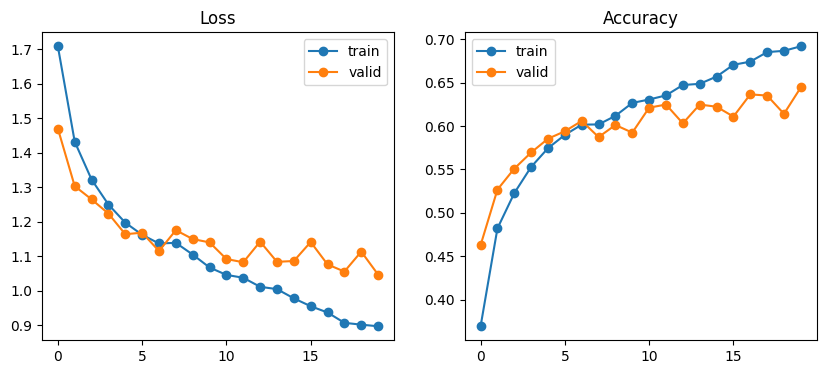

In [49]:
plot_graphs(hist)

In [57]:
# Evaluate trained model on validation dataset

def validation_eval(val_loader):
    """
    Function to evaluate the trained model on validation dataset.
    
    Args:
        val_loader (DataLoader): The validation dataloader.
    Returns:
        val_acc (float): The validation accuracy.
    """
    alexnet_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            # images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = alexnet_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total
    print("Validation accuracy: {}%".format(val_acc))
    return val_acc

validation_eval(val_loader)


Validation accuracy: 65.92%


65.92

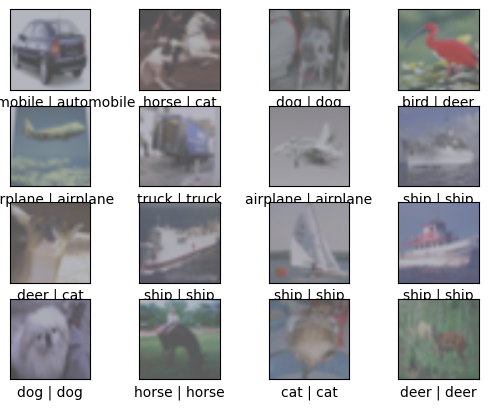

In [61]:
# from libcnnutils import visualize_predictions

import matplotlib.pyplot as plt

def visualize_predictions(model, data_loader, class_names, mean, std, num_samples=16):
    """
    Visualizes predictions made by a model on a test or validation set.

    Args:
    model (torch.nn.Module): The trained model.
    data_loader (torch.utils.data.DataLoader): The data loader for the test or validation set.
    class_names (list): A list of class names.
    mean (tuple): A tuple of mean values for each channel of the input images.
    std (tuple): A tuple of standard deviation values for each channel of the input images.
    num_samples (int): The number of samples to visualize. Default is 16.

    Returns:
    None
    """
    model.eval()
    with torch.no_grad():
        for idx, (images, labels) in enumerate(data_loader):
            if idx * images.shape[0] >= num_samples:
                break
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for j in range(images.shape[0]):
                if (idx * images.shape[0] + j) >= num_samples:
                    break
                plt.subplot(4, 4, idx * images.shape[0] + j + 1)
                plt.xticks([])
                plt.yticks([])
                plt.grid(False)
                plt.imshow((images[j].cpu().numpy().transpose(1, 2, 0) * std + mean).clip(0, 1))
                plt.xlabel(f'{class_names[labels[j]]} | {class_names[preds[j]]}')
    plt.show()

# Visualize predictions on validation dataset
visualize_predictions(alexnet_model, val_loader, class_names=classnames, mean=[0.5,0.5,0.5], std=[0.2,0.2,0.2], num_samples=16)

In [67]:
# To Check number of parameters in the model

from torchvision.models import alexnet

# Create an instance of the AlexNet model
model = alexnet()
# Count the total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

# NOTE - from my libcnn 
mymodel = AlexNet(num_classes=10)
# Count the total number of parameters in the model
total_params = sum(p.numel() for p in mymodel.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 61100840
Total number of parameters: 58322314
